## Example 2: Logistic regression

Import libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.special import expit as invlogit

In [2]:
az.style.use('arviz-darkgrid')
np.random.seed(1234)

Read data

In [3]:
data = pd.read_csv('data/ANES_2016_pilot.csv')
print(data.shape)
data.head()

(421, 3)


,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Subset data

In [4]:
clinton_data = data.loc[data['vote'].isin(['clinton', 'trump']), :]
print(clinton_data.shape)
clinton_data.head()

(373, 3)


,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Fit model

In [5]:
clinton_model = bmb.Model(clinton_data)
clinton_fitted = clinton_model.fit(
    "vote['clinton'] ~ party_id + party_id:age",
    family="bernoulli",
    tune=2000,
    draws=2000
)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


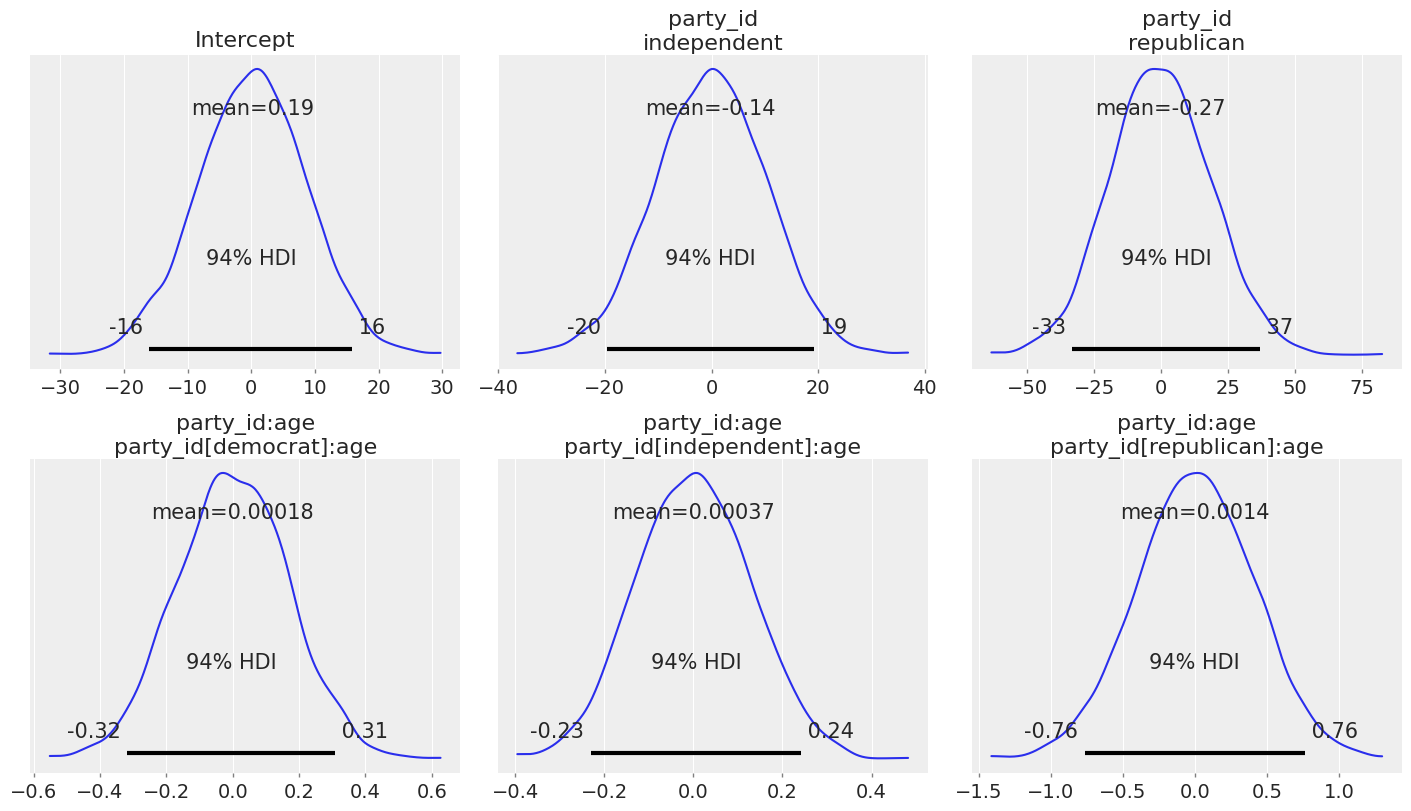

In [6]:
clinton_model.plot_priors(figsize = (14, 8));
plt.savefig("imgs/clinton_prior.png")

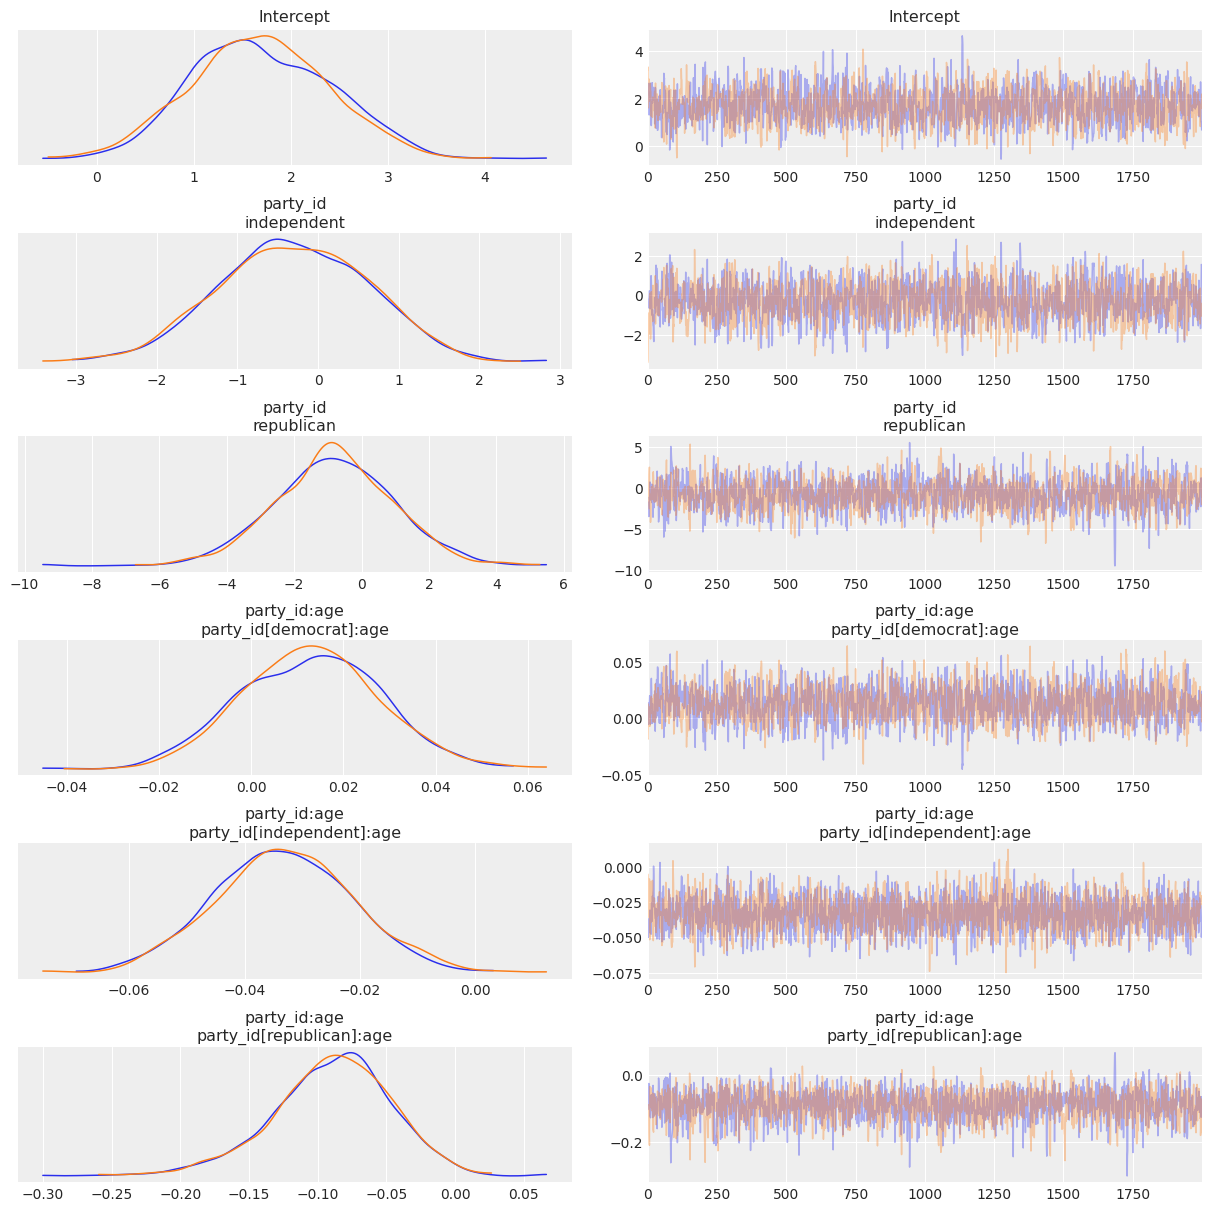

In [7]:
az.plot_trace(clinton_fitted, compact=False);
plt.savefig("imgs/clinton_posterior.png")

In [8]:
# We need to automatically add labels to InferenceData object to recover this by_label selection
parties = ['democrat', 'independent', 'republican']
party_idx = [0, 1, 2]
dem, ind, rep = [clinton_fitted.posterior['party_id:age'][:,:,x].values for x in party_idx]

In [9]:
slopes = clinton_fitted.posterior['party_id:age'].values.reshape(4000, 3).T

intercept_dem = clinton_fitted.posterior['Intercept'].squeeze().values.reshape(-1,)
intercept_ind = intercept_dem + clinton_fitted.posterior['party_id'][:,:,0].values.reshape(-1,)
intercept_rep = intercept_dem + clinton_fitted.posterior['party_id'][:,:,1].values.reshape(-1,)

intercepts = [intercept_dem, intercept_ind, intercept_rep]

X = np.hstack([np.array([1] * len(np.arange(18, 91)))[:, None], np.arange(18, 91)[:, None]])
yhat = [invlogit(np.dot(X, np.vstack([intercepts[i], slopes[i]]))) for i in range(3)]

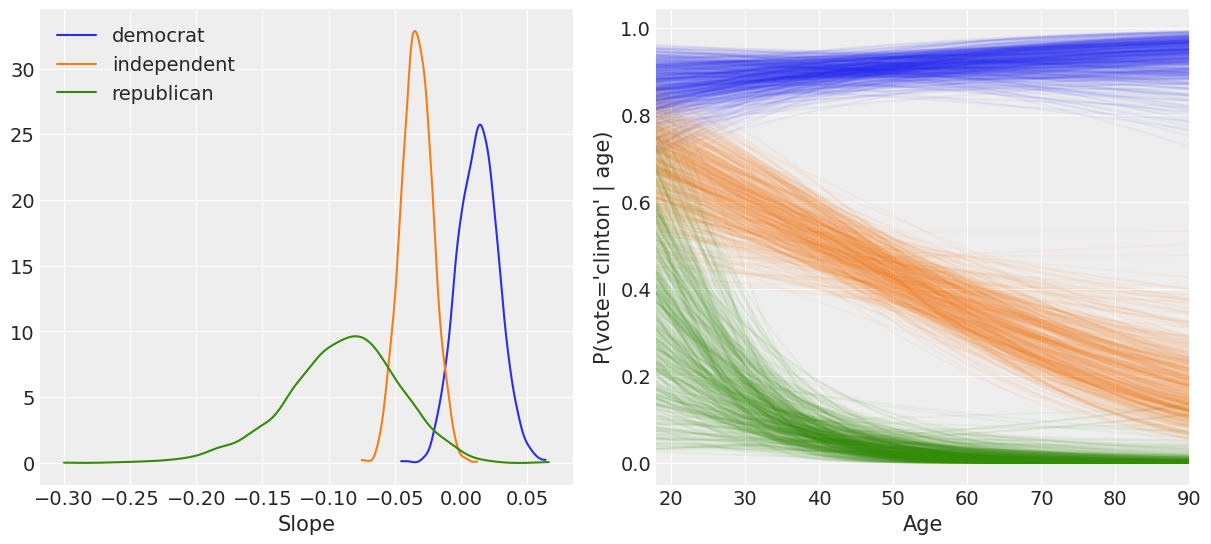

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 5.33))

for idx, x in enumerate([dem, ind, rep]):
    az.plot_kde(x, label=f'{parties[idx]}', plot_kwargs={'color':f'C{idx}'}, ax=ax[0])
ax[0].legend(loc='upper left');
ax[0].set_xlabel('Slope')

for i in range(3):
    for t in range(500):
        ax[1].plot(X[:, 1], yhat[i][:, t], alpha=0.05, color=f'C{i}')
ax[1].set_ylabel('P(vote=\'clinton\' | age)')
ax[1].set_xlabel('Age')
ax[1].set_xlim(18, 90);
plt.savefig("imgs/clinton_results.png")

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Mar 08 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

pandas    : 1.2.2
numpy     : 1.20.1
arviz     : 0.11.2
matplotlib: 3.3.3
bambi     : 0.4.0

Watermark: 2.1.0

